In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Загрузим [набор данных гамма-телескопа](https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data):

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data',
                 names = [ 'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 
                          'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'])

df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
ans_dict = {'g': 0, 'h': 1}

X = df.drop('class', axis=1)
y = df['class'].replace(ans_dict)

scaler = StandardScaler()
X = scaler.fit_transform(X, y)

feature_num = len(X[0])

Построим нейросеть, которая будет решать данную задачу классификации.

In [5]:
def LossFunction(y, y_predicted):
    crossentropy = y * torch.log(y_predicted).view(1, len(y))[0] + (1 - y) * torch.log(y_predicted).view(1, len(y))[0]
    loss = -torch.sum(crossentropy)/len(crossentropy)
    return loss


def nnet(X, y, X_test, Y_test, in_dim, n_samples='all', max_iter=1000):
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(in_dim, 10))
    model.add_module('hl', nn.ReLU())
    model.add_module('hl1', nn.Linear(10, 1))
    model.add_module('l2', nn.Sigmoid())
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    train_err = []
    test_err = []

    x_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(Y_test, dtype=torch.float32)
    
    for i in range(max_iter):
        
        if(n_samples == 'all'):
            X_train = X
            y_train = y
        else:
        # sample ix random objects
            ix = np.random.randint(0, len(X), n_samples)
            X_train = X[ix]
            y_train = y[ix]
    
        x_batch = torch.tensor(X, dtype=torch.float32)
        y_batch = torch.tensor(y, dtype=torch.float32)
    # predict probabilities
        y_predicted = model(x_batch)
        y_test_pred = model(x_test)
        
    # compute loss
        loss = LossFunction(y_batch, y_predicted)
    
    # compute gradients
        loss.backward() 
    
    # Adam step
        opt.step()
    
    # clear gradients
        opt.zero_grad()
    
        train_err.append(loss.data.numpy())
        test_err.append(LossFunction(y_test, y_test_pred).data.numpy())
        
    return train_err, test_err

Разделим выборку на обучение и тест, не перемешивая её:

In [6]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, shuffle=False,
                                     test_size=0.4)

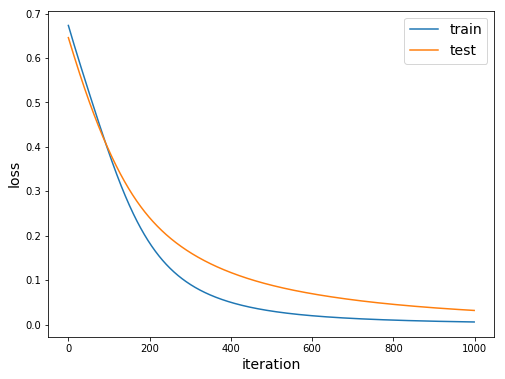

In [9]:
train_loss, test_loss = nnet(np.array(X_train), np.array(y_train), 
                             np.array(X_test), np.array(y_test), feature_num)

plt.figure(figsize = (8, 6))
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(test_loss)), test_loss, label='test')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)

Разделим стратифицированную выборку на обучение и тест:

In [10]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, stratify=y,
                                     test_size=0.4, random_state=12)

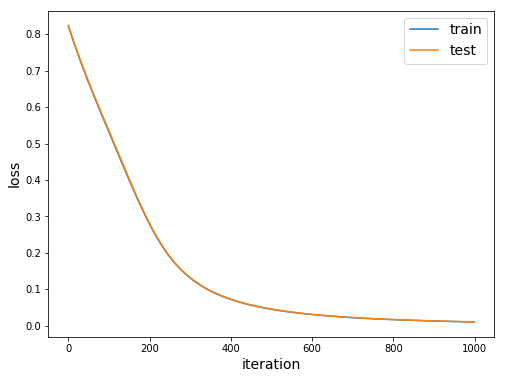

In [12]:
train_loss, test_loss = nnet(np.array(X_train), np.array(y_train), 
                             np.array(X_test), np.array(y_test), feature_num)

plt.figure(figsize = (8, 6))
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(test_loss)), test_loss, label='test')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)

Для разных объемов выборки построим графики кривой обучения, показывающие различные скорости обучения.

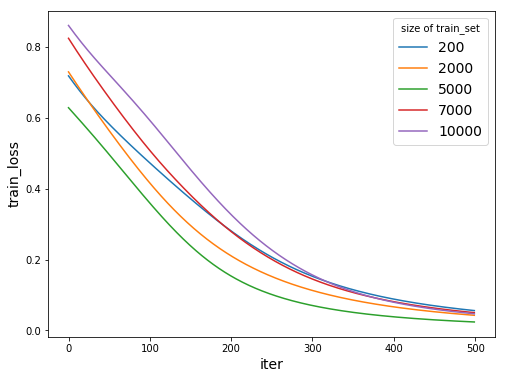

In [13]:
size_of_train_set = [200, 2000, 5000, 7000, 10000]
tr_loss = []
t_loss = []

for s in size_of_train_set:
    train_loss_s, test_loss_s = nnet(np.array(X_train), np.array(y_train),
                                 np.array(X_test), np.array(y_test),
                                 feature_num, n_samples=s, max_iter=500)
    tr_loss.append(train_loss_s)
    t_loss.append(test_loss_s)

plt.figure(figsize = (8, 6))
x_ = list(range(500))
for i, s in enumerate(size_of_train_set):
    plt.plot(x_, tr_loss[i], label=str(s))
    
plt.xlabel('iter', fontsize=14)
plt.ylabel('train_loss', fontsize=14)
plt.legend(title='size of train_set', fontsize=14)

Наложим на выборку шум. Построим несколько графиков кривой обучения в условиях наложенного шума с разной дисперсией.

In [14]:
noise = np.random.normal(loc=0.0, scale=1.0, size=X.shape)

X_noised = X + noise
(X_train, X_test, 
 y_train, y_test) = train_test_split(X_noised, y, stratify=y,
                                     test_size=0.4, random_state=12)

train_loss_noise1, test_loss_noise1= nnet(np.array(X_train), np.array(y_train), 
                                          np.array(X_test), np.array(y_test), feature_num)

In [15]:
noise = np.random.normal(loc=0.0, scale=1.5, size=X.shape)

X_noised = X + noise
(X_train, X_test, 
 y_train, y_test) = train_test_split(X_noised, y, stratify=y,
                                     test_size=0.4, random_state=12)

train_loss_noise2, test_loss_noise2= nnet(np.array(X_train), np.array(y_train), 
                                          np.array(X_test), np.array(y_test), feature_num)

In [16]:
noise = np.random.normal(loc=0.0, scale=2.0, size=X.shape)

X_noised = X + noise
(X_train, X_test, 
 y_train, y_test) = train_test_split(X_noised, y, stratify=y,
                                     test_size=0.4, random_state=12)

train_loss_noise3, test_loss_noise3= nnet(np.array(X_train), np.array(y_train), 
                                          np.array(X_test), np.array(y_test), feature_num)

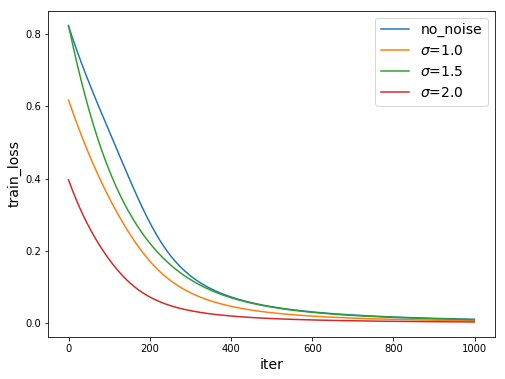

In [18]:
plt.figure(figsize = (8, 6))
plt.plot(range(len(train_loss)), train_loss, label='no_noise')
plt.plot(range(len(train_loss)), train_loss_noise1, label='$\sigma$=1.0')
plt.plot(range(len(train_loss)), train_loss_noise2, label='$\sigma$=1.5')
plt.plot(range(len(train_loss)), train_loss_noise3, label='$\sigma$=2.0')
plt.xlabel('iter', fontsize=14)
plt.ylabel('train_loss', fontsize=14)
plt.legend(fontsize=14)